In [1]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import networkx as nx
import random
import os

from torch.distributions import Categorical, Bernoulli


import json

from agents.option_critic import OptionCriticFeatures
from agents.option_critic_nn import OptionCriticNeuralNetwork
from agents.option_networks import TerminationFunctionNetwork
from agents.option_networks import ReluNetwork
from agents.option_networks import QNetwork

from utils import utils


/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_FOLDER = './evaluations'
N_OPTIONS = 3
TRAFFIC = "custom-2way-single-intersection3"
# MODEL = f"option_critic_nn_100000_steps_curriculum_3_options_custom-2way-single-intersection3_100000_steps"
MODEL = "option_critic_nn_curriculum_3_options_custom-2way-single-intersection3_50000_steps"
PREFIX = f"{MODEL}_{TRAFFIC}"                                              

In [3]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = None
    # df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def get_obs(df, index):
    current_option = df.option.to_list()[index]
    total_observation = []
    unnested_obs = {}
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():
    #   current_time = observation_dict["current_time"]
        phase_ids = observation_dict["phase_ids"]
        min_green = observation_dict["min_green"]
        density = observation_dict["density"]
        queue = observation_dict["queue"]
        delta_queue = observation_dict["delta_queue"]
        observation = phase_ids + min_green + density + queue + delta_queue
        total_observation.extend(observation)
        for key, value in observation_dict.items():
            if isinstance(value, list):
                for index, item in enumerate(value):
                    unnested_obs[f"{tf_id}_{key}_{index}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)
    encoded_option = np.zeros(N_OPTIONS)
    encoded_option[current_option] = 1
    total_observation = np.append(total_observation, encoded_option)
    
    for o in range(N_OPTIONS):
        key = f"option_{o}"
        if o == current_option:
            value = 1
        else:
            value = 0
        unnested_obs[f"{tf_id}_{key}"] = value

    return total_observation, current_option, unnested_obs

def get_random_obs(df):
    index = random.randrange(df.shape[0])
    return get_obs(df, index)

def prep_state(obs):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)


    # include option information
    # Simplified to make it easier to manage
    # encoded_option = np.zeros(self.num_options)
    # encoded_option[self.current_option] = 1
    # obs = np.append(obs, encoded_option)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor


In [44]:
df_single_episode, _ = load_data(PREFIX)

model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = model_params['Q']
termination_network_params = model_params['terminations']

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")

termination_model.load_state_dict(termination_network_params)

q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")

q_model.load_state_dict(q_model_params)


/tmp/ipykernel_16155/660746802.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(


<All keys matched successfully>

<Axes: xlabel='step'>

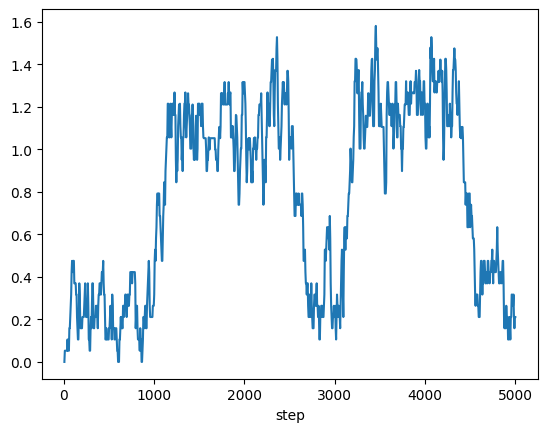

In [45]:
df_single_episode.lane_density.plot()

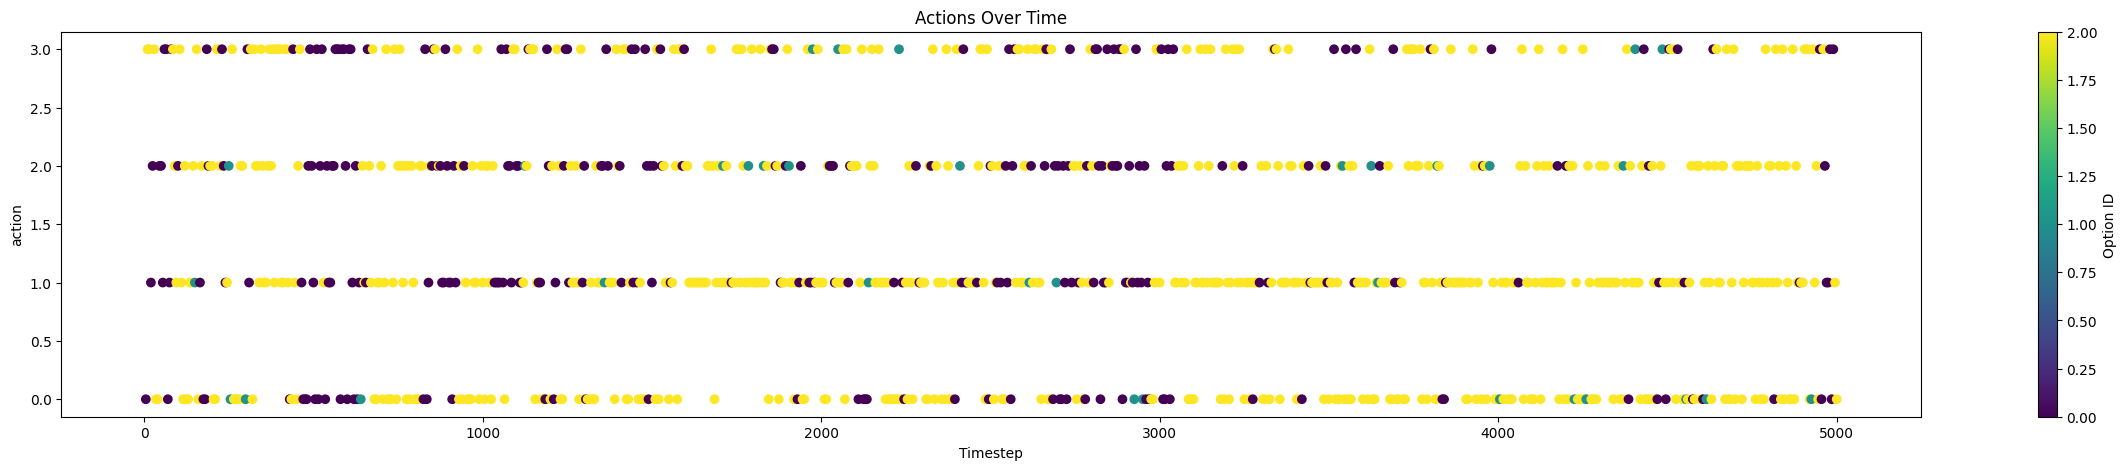

In [46]:
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

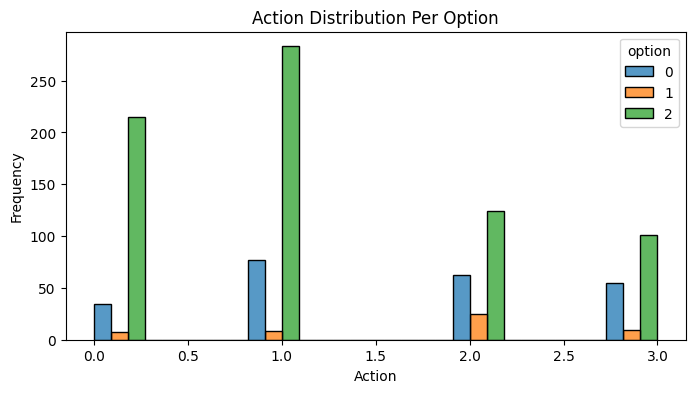

In [40]:
plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

In [41]:
[(i, value) for i, value in enumerate(df_single_episode.termination_prob.to_list())]

[(0, 0.5237115621566772),
 (1, 0.5399302244186401),
 (2, 0.6194286942481995),
 (3, 0.5243610739707947),
 (4, 0.5725347995758057),
 (5, 0.5385431051254272),
 (6, 0.6205101609230042),
 (7, 0.7386382222175598),
 (8, 0.7672853469848633),
 (9, 0.8055009841918945),
 (10, 0.6967630982398987),
 (11, 0.5629984140396118),
 (12, 0.6893043518066406),
 (13, 0.8081632256507874),
 (14, 0.8060822486877441),
 (15, 0.7500782608985901),
 (16, 0.9047189354896544),
 (17, 0.847968339920044),
 (18, 0.9151881337165833),
 (19, 0.9083161950111388),
 (20, 0.8899339437484741),
 (21, 0.8924577832221985),
 (22, 0.9698650240898132),
 (23, 0.9828051924705504),
 (24, 0.9866833090782166),
 (25, 0.9768856763839722),
 (26, 0.9832766056060792),
 (27, 0.9851638078689576),
 (28, 0.9854770302772522),
 (29, 0.9854770302772522),
 (30, 0.9854770302772522),
 (31, 0.9854770302772522),
 (32, 0.9903772473335266),
 (33, 0.9554953575134276),
 (34, 0.8931726813316345),
 (35, 0.9881153106689452),
 (36, 0.9543995261192322),
 (37, 0.8635

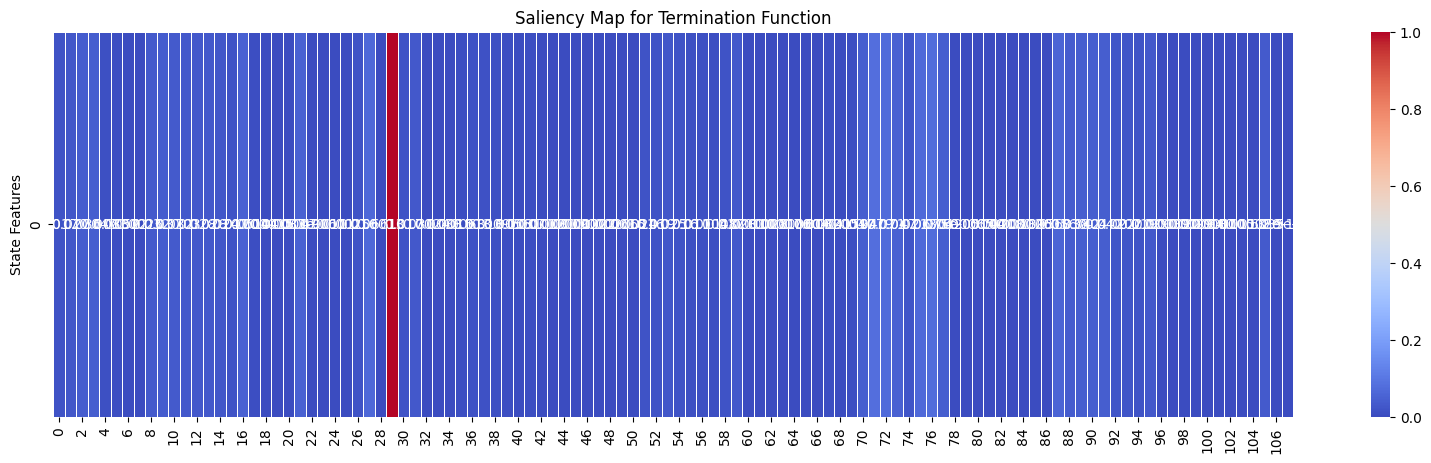

In [35]:
obs, current_option, unnested_dict = get_random_obs(df_single_episode)
state = prep_state(obs)
state = state.clone().detach().requires_grad_(True)
# Forward pass
termination_prob = termination_model(state)[:, current_option]

# Compute gradients w.r.t input state
termination_prob.backward()

# Get absolute gradient values (saliency)
saliency = state.grad.abs().detach().numpy()

# Normalize for visualization
saliency /= saliency.max()

# Plot saliency map
plt.figure(figsize=(20, 5))
sns.heatmap(saliency.reshape(1, -1), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Saliency Map for Termination Function")
plt.ylabel("State Features")
plt.show()

In [16]:
for index, key in enumerate(unnested_dict):
    print(index, key)

0 t_phase_ids_0
1 t_phase_ids_1
2 t_phase_ids_2
3 t_phase_ids_3
4 t_phase_ids_4
5 t_phase_ids_5
6 t_phase_ids_6
7 t_phase_ids_7
8 t_phase_ids_8
9 t_phase_ids_9
10 t_phase_ids_10
11 t_phase_ids_11
12 t_phase_ids_12
13 t_phase_ids_13
14 t_phase_ids_14
15 t_phase_ids_15
16 t_min_green_0
17 t_density_0
18 t_density_1
19 t_density_2
20 t_density_3
21 t_density_4
22 t_density_5
23 t_density_6
24 t_density_7
25 t_queue_0
26 t_queue_1
27 t_queue_2
28 t_queue_3
29 t_queue_4
30 t_queue_5
31 t_queue_6
32 t_queue_7
33 t_delta_queue_0
34 t_delta_queue_1
35 t_delta_queue_2
36 t_delta_queue_3
37 t_delta_queue_4
38 t_delta_queue_5
39 t_delta_queue_6
40 t_delta_queue_7
41 t_option_0
42 t_option_1
43 t_option_2


In [43]:
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    state = prep_state(obs)
#     print(index, json.dumps(unnested_dict, indent=4))
    print(index * 5, current_option, "\n", df_single_episode.termination_prob.to_list()[index], q_model(state), termination_model(state))

0 2 
 0.5237115621566772 tensor([[104.2049, 101.2204, 101.7442]], grad_fn=<AddmmBackward0>) tensor([[0.4829, 0.1613, 0.0757]], grad_fn=<AddmmBackward0>)
5 1 
 0.5399302244186401 tensor([[121.2071, 117.7378, 117.3066]], grad_fn=<AddmmBackward0>) tensor([[0.4871, 0.1678, 0.0814]], grad_fn=<AddmmBackward0>)
10 0 
 0.6194286942481995 tensor([[128.9907, 126.0195, 128.0031]], grad_fn=<AddmmBackward0>) tensor([[0.4985, 0.1855, 0.0968]], grad_fn=<AddmmBackward0>)
15 2 
 0.5243610739707947 tensor([[114.8608, 111.8501, 113.6993]], grad_fn=<AddmmBackward0>) tensor([[0.6549, 0.4278, 0.3083]], grad_fn=<AddmmBackward0>)
20 2 
 0.5725347995758057 tensor([[104.6694, 105.8653, 111.2606]], grad_fn=<AddmmBackward0>) tensor([[0.5203, 0.2192, 0.1262]], grad_fn=<AddmmBackward0>)
25 2 
 0.5385431051254272 tensor([[114.4865, 115.4659, 117.9441]], grad_fn=<AddmmBackward0>) tensor([[ 0.1604, -0.3397, -0.3647]], grad_fn=<AddmmBackward0>)
30 2 
 0.6205101609230042 tensor([[135.7302, 131.2384, 137.4679]], grad_fn=

735 2 
 0.977203130722046 tensor([[100.3201,  99.6773, 102.2875]], grad_fn=<AddmmBackward0>) tensor([[3.3126, 4.5484, 3.9096]], grad_fn=<AddmmBackward0>)
740 2 
 0.9806750416755676 tensor([[99.9733, 98.2691, 99.7077]], grad_fn=<AddmmBackward0>) tensor([[3.0704, 4.1731, 3.5822]], grad_fn=<AddmmBackward0>)
745 0 
 0.9657896161079408 tensor([[100.8234,  98.5106, 100.3123]], grad_fn=<AddmmBackward0>) tensor([[4.0928, 5.7584, 4.9684]], grad_fn=<AddmmBackward0>)
750 0 
 0.9841280579566956 tensor([[90.4080, 88.6552, 89.5229]], grad_fn=<AddmmBackward0>) tensor([[3.8080, 5.3168, 4.5824]], grad_fn=<AddmmBackward0>)
755 0 
 0.9788020849227904 tensor([[78.5710, 77.3923, 77.2717]], grad_fn=<AddmmBackward0>) tensor([[4.4351, 6.2895, 5.4337]], grad_fn=<AddmmBackward0>)
760 0 
 0.9866201877593994 tensor([[91.4842, 88.9390, 90.0316]], grad_fn=<AddmmBackward0>) tensor([[4.6029, 6.5502, 5.6629]], grad_fn=<AddmmBackward0>)
765 0 
 0.9912229776382446 tensor([[87.9575, 86.1130, 85.9662]], grad_fn=<AddmmBack

1735 1 
 0.999747097492218 tensor([[113.7952, 110.8507, 109.6092]], grad_fn=<AddmmBackward0>) tensor([[6.1796, 8.9963, 7.8053]], grad_fn=<AddmmBackward0>)
1740 0 
 0.9977341890335084 tensor([[99.3515, 99.2722, 99.0439]], grad_fn=<AddmmBackward0>) tensor([[6.1377, 8.9320, 7.7505]], grad_fn=<AddmmBackward0>)
1745 2 
 0.9995468258857728 tensor([[102.7199, 103.3600, 105.5816]], grad_fn=<AddmmBackward0>) tensor([[ 7.0384, 10.3300,  8.9767]], grad_fn=<AddmmBackward0>)
1750 2 
 0.9998252987861632 tensor([[103.0618, 102.5663, 105.0191]], grad_fn=<AddmmBackward0>) tensor([[6.7633, 9.9032, 8.6026]], grad_fn=<AddmmBackward0>)
1755 2 
 0.9998502731323242 tensor([[110.9025, 110.4899, 110.2279]], grad_fn=<AddmmBackward0>) tensor([[5.6259, 8.1379, 7.0551]], grad_fn=<AddmmBackward0>)
1760 0 
 0.9979800581932068 tensor([[113.6814, 113.3083, 114.6417]], grad_fn=<AddmmBackward0>) tensor([[4.5487, 6.4664, 5.5906]], grad_fn=<AddmmBackward0>)
1765 0 
 0.9949430823326112 tensor([[101.6341, 101.2781, 103.8213

2890 0 
 0.9993541836738586 tensor([[115.9578, 115.1915, 118.0524]], grad_fn=<AddmmBackward0>) tensor([[ 7.3480, 10.8108,  9.3992]], grad_fn=<AddmmBackward0>)
2895 2 
 0.99991774559021 tensor([[116.2226, 115.6650, 118.2395]], grad_fn=<AddmmBackward0>) tensor([[ 7.3879, 10.8729,  9.4540]], grad_fn=<AddmmBackward0>)
2900 2 
 0.99990975856781 tensor([[117.6994, 117.0229, 119.7824]], grad_fn=<AddmmBackward0>) tensor([[ 7.2810, 10.7069,  9.3079]], grad_fn=<AddmmBackward0>)
2905 2 
 0.9999130964279176 tensor([[117.7133, 117.4275, 119.6004]], grad_fn=<AddmmBackward0>) tensor([[ 7.3302, 10.7832,  9.3749]], grad_fn=<AddmmBackward0>)
2910 2 
 0.9999169111251832 tensor([[116.6807, 116.4259, 118.9557]], grad_fn=<AddmmBackward0>) tensor([[6.7633, 9.9028, 8.6016]], grad_fn=<AddmmBackward0>)
2915 2 
 0.9998774528503418 tensor([[117.4414, 117.4473, 118.8290]], grad_fn=<AddmmBackward0>) tensor([[6.0849, 8.8499, 7.6782]], grad_fn=<AddmmBackward0>)
2920 0 
 0.9980555772781372 tensor([[112.9300, 113.9453,

4020 2 
 0.9997947812080384 tensor([[276.1194, 269.1459, 287.7312]], grad_fn=<AddmmBackward0>) tensor([[6.5163, 9.5181, 8.2602]], grad_fn=<AddmmBackward0>)
4025 2 
 0.9997286200523376 tensor([[277.4798, 272.5786, 293.8688]], grad_fn=<AddmmBackward0>) tensor([[6.4382, 9.3968, 8.1538]], grad_fn=<AddmmBackward0>)
4030 2 
 0.9997506737709044 tensor([[236.8206, 234.6786, 260.7945]], grad_fn=<AddmmBackward0>) tensor([[6.5331, 9.5443, 8.2837]], grad_fn=<AddmmBackward0>)
4035 2 
 0.9997307658195496 tensor([[241.2163, 240.6283, 267.0282]], grad_fn=<AddmmBackward0>) tensor([[6.1052, 8.8796, 7.6994]], grad_fn=<AddmmBackward0>)
4040 2 
 0.99965500831604 tensor([[245.0476, 243.3775, 271.0696]], grad_fn=<AddmmBackward0>) tensor([[6.1739, 8.9864, 7.7935]], grad_fn=<AddmmBackward0>)
4045 2 
 0.9994656443595886 tensor([[239.8213, 237.6149, 264.0107]], grad_fn=<AddmmBackward0>) tensor([[5.8751, 8.5226, 7.3869]], grad_fn=<AddmmBackward0>)
4050 2 
 0.9993762373924256 tensor([[246.9003, 245.4511, 272.0047]

4890 2 
 0.8883498907089233 tensor([[110.8802, 108.2592, 114.0983]], grad_fn=<AddmmBackward0>) tensor([[3.0718, 4.1746, 3.5819]], grad_fn=<AddmmBackward0>)
4895 2 
 0.9697712063789368 tensor([[122.9592, 121.9588, 127.5801]], grad_fn=<AddmmBackward0>) tensor([[1.7765, 2.1663, 1.8264]], grad_fn=<AddmmBackward0>)
4900 2 
 0.8789954781532288 tensor([[122.4273, 123.2072, 143.0457]], grad_fn=<AddmmBackward0>) tensor([[2.1699, 2.7759, 2.3586]], grad_fn=<AddmmBackward0>)
4905 2 
 0.917338490486145 tensor([[112.4048, 111.4591, 117.6932]], grad_fn=<AddmmBackward0>) tensor([[1.9077, 2.3696, 2.0039]], grad_fn=<AddmmBackward0>)
4910 2 
 0.9019906520843506 tensor([[107.4515, 105.2648, 113.1334]], grad_fn=<AddmmBackward0>) tensor([[1.9126, 2.3769, 2.0095]], grad_fn=<AddmmBackward0>)
4915 2 
 0.9086815118789672 tensor([[132.0570, 124.9778, 129.4768]], grad_fn=<AddmmBackward0>) tensor([[2.8435, 3.8225, 3.2792]], grad_fn=<AddmmBackward0>)
4920 2 
 0.6750978827476501 tensor([[111.0046, 111.7667, 118.9737

In [154]:
def create_feature_df(df):
    feature_list = []
    option_list = df.option.to_list()
    for index, obs_item in enumerate(df.obs.to_list()):
        unnested_obs = {}
        for tf_id, observation_dict in json.loads(obs_item).items():
            for key, value in observation_dict.items():
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        unnested_obs[f"{tf_id}_{key}_{index}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
        current_option = int(option_list[index])
        for o in range(N_OPTIONS):
            key = f"option_{o}"
            if o == current_option:
                value = 1
            else:
                value = 0
            unnested_obs[f"{tf_id}_{key}"] = value
                    
        feature_list.append(unnested_obs)
    return pd.DataFrame(feature_list)

features = create_feature_df(df_single_episode)

In [155]:
def f(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = termination_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer = shap.KernelExplainer(f, features.iloc[:50, :])
shap_values = explainer.shap_values(features.iloc[:, :], nsamples=50)

  1%|█                                                                                                                                              | 7/1000 [00:03<08:55,  1.85it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=4.980e-07, previous alpha=4.879e-07, with an active set of 25 regressors.
  warnings.warn(
  2%|██▏                                                                                                                                           | 15/1000 [00:08<09:37,  1.71it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.165e-03, with an active set of 5 regressors, and the smallest chole

 11%|███████████████▌                                                                                                                             | 110/1000 [01:03<09:10,  1.62it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.723e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.699e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-pack

 18%|█████████████████████████▌                                                                                                                   | 181/1000 [01:42<07:18,  1.87it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.362e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.133e-05, previous alpha=6.781e-06, with an active set of 23 regressors.
  warnings.warn(
 20%|████████████████████████████                                                  

 37%|████████████████████████████████████████████████████▎                                                                                        | 371/1000 [03:32<06:48,  1.54it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.058e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=7.252e-06, previous alpha=7.252e-06, with an active set of 25 regressors.
  warnings.warn(
 39%|██████████████████████████████████████████████████████▊                       

 46%|█████████████████████████████████████████████████████████████████                                                                            | 461/1000 [04:22<06:36,  1.36it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.527e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=7.633e-05, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 509/1000 [05:22<10:31,  1.29s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.779e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.534e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 606/1000 [06:38<04:53,  1.34it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.178e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.089e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 639/1000 [07:00<04:02,  1.49it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.110e-05, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.201e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 744/1000 [08:03<02:11,  1.94it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=7.217e-07, previous alpha=7.217e-07, with an active set of 23 regressors.
  warnings.warn(
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 746/1000 [08:04<01:57,  2.17it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=4.128e-07, with an active set of 27 regressors, and the smallest cho

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 797/1000 [08:32<01:58,  1.72it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.270e-05, previous alpha=1.165e-05, with an active set of 21 regressors.
  warnings.warn(
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 815/1000 [08:42<01:38,  1.88it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.071e-06, with an active set of 19 regressors, and the smallest cho

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 857/1000 [09:16<02:35,  1.08s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=2.777e-04, previous alpha=2.427e-04, with an active set of 12 regressors.
  warnings.warn(
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 860/1000 [09:18<01:55,  1.21it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=7.743e-05, with an active set of 18 regressors, and the smallest cho

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 951/1000 [10:20<00:35,  1.37it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.890e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.428e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-pac

In [156]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features)

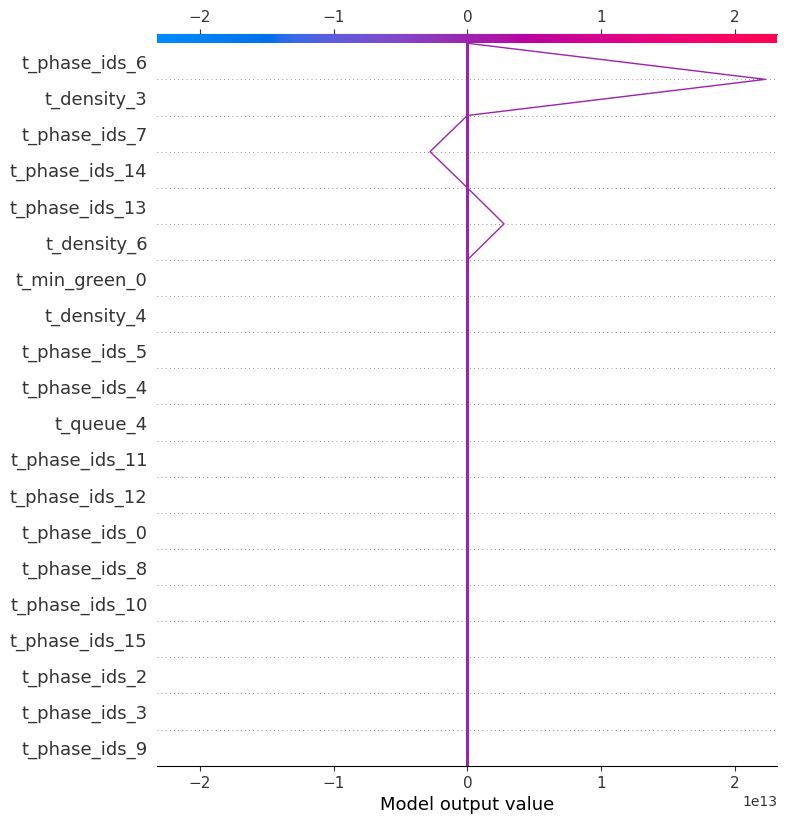

In [157]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values, features)

In [158]:
def f_q_values(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = q_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer_q_model = shap.KernelExplainer(f_q_values, features.iloc[:50, :])
shap_values_q_model = explainer_q_model.shap_values(features.iloc[:, :], nsamples=50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:16<00:00,  1.09it/s]


In [159]:
shap.initjs()
shap.force_plot(shap_values_q_model.expected_value, shap_values_q_model, features)

AttributeError: 'numpy.ndarray' object has no attribute 'expected_value'

In [ ]:
shap.initjs()
shap.decision_plot(shap_values_q_model.expected_value, shap_values_q_model, features)

In [ ]:
##########
# Backup #
##########

In [ ]:
states = df_single_episode.obs.to_list()
options = df_single_episode.option.to_list()
n = df_single_episode.shape[0]
G = nx.DiGraph()

# Add nodes with positions
node_colors = []
for i in range(n):
    G.add_node(states[i], option=options[i])
    node_colors.append(options[i])

# Add directed edges based on actions
for i in range(n - 1):
    G.add_edge(i, i + 1, action=i)

# Draw graph
plt.figure(figsize=(8, 6))
print("Drawing graph")
nx.draw(
    G, with_labels=True,cmap=plt.cm.viridis,
    edge_color="gray", node_size=300, font_size=8, font_color="white",
    arrows=True, arrowsize=10
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)

plt.title("State-Action Network with Termination States")
plt.show()

In [ ]:
model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = {}
termination_network_params = {}

for key, value in model_params.items():
    if key.startswith('Q'):
        q_model_params[key] = value
    elif key.startswith("terminations"):
        termination_network_params[key] = value
    else:
        print(f"Unknown key {key}")

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")
q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")